In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import time
import seaborn as sns
from datetime import datetime as dt
from models.Regression import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from copy import deepcopy

In [4]:
data_name ='housing_price'

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.fillna({'Alley':'None', 'BsmtQual':'None','BsmtCond':'None','BsmtExposure':'None','BsmtFinType1':'None','BsmtFinType2':'None','FireplaceQu':'None','GarageType':'None',
              'MasVnrType':'None','GarageFinish':'None','GarageQual':'None','GarageCond':'None','PoolQC':'None','MiscFeature':'None','Fence':'None'}, inplace=True)
test.fillna({'Alley':'None', 'BsmtQual':'None','BsmtCond':'None','BsmtExposure':'None','BsmtFinType1':'None','BsmtFinType2':'None','FireplaceQu':'None','GarageType':'None',
              'MasVnrType':'None','GarageFinish':'None','GarageQual':'None','GarageCond':'None','PoolQC':'None','MiscFeature':'None','Fence':'None'}, inplace=True)

In [7]:
obs = len(train)

# Divide obs in half to get half batch size
batch_size = obs // 2

In [8]:
nan_columns = train[train.columns[train.isna().any()]]
cols = train.columns
num_cols = train._get_numeric_data().columns
categorical_columns = list(set(cols) - set(num_cols))

In [9]:
label_encoder = LabelEncoder()
for col_name in categorical_columns:
    series_train = train[col_name]
    series_test = train[col_name]
    train[col_name] = pd.Series(
        label_encoder.fit_transform(series_train[series_train.notnull()]),
        index=series_train[series_train.notnull()].index)
    test[col_name] = pd.Series(
        label_encoder.fit_transform(series_test[series_test.notnull()]),
        index=series_test[series_test.notnull()].index)

In [10]:
train.dropna(inplace=True) 

In [11]:
num_col = train[num_cols]
cat_col = train[categorical_columns]
y = train.SalePrice.squeeze()

In [12]:
def get_high_corr_list(X: pd.DataFrame, y: pd.Series, threshold: float) -> list:
    # create the list of features with corr_abs > 0.5
    corr_abs = np.abs(X.corrwith(y))
    strong_corr = corr_abs[corr_abs> threshold]
    features = list(strong_corr.index)
    return features

In [13]:
feature_list_num = get_high_corr_list(num_col, y, 0.01)

In [14]:
feature_list_cat = get_high_corr_list(cat_col, y, 0.01)

In [15]:
y = ['SalePrice']

train_feature_num = train[feature_list_num].copy()
train_feature_cat = train[feature_list_cat].copy()

for cat in train_feature_cat.columns:
    train_feature_cat.loc[:, cat] = train_feature_cat.loc[:, cat].astype('category')

cats = np.stack([train_feature_cat[col].cat.codes.values for col in train_feature_cat.columns], 1)
cats = torch.tensor(cats, dtype=torch.int64)

conts = np.stack([train_feature_num[col].values for col in train_feature_num.columns], 1)
conts = torch.tensor(conts, dtype=torch.float)

y = torch.tensor(train[y].values, dtype=torch.float).reshape(-1,1)

cat_szs = [len(train_feature_cat[col].cat.categories) for col in train_feature_cat.columns]


In [16]:
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(emb_szs)

[(5, 3), (25, 13), (4, 2), (8, 4), (2, 1), (5, 3), (6, 3), (5, 3), (4, 2), (6, 3), (5, 3), (2, 1), (3, 2), (5, 3), (4, 2), (7, 4), (6, 3), (9, 5), (7, 4), (3, 2), (3, 2), (6, 3), (9, 5), (4, 2), (5, 3), (7, 4), (6, 3), (3, 2), (5, 3), (5, 3), (4, 2), (4, 2), (16, 8), (5, 3), (5, 3), (6, 3), (5, 3), (4, 2), (5, 3), (5, 3), (4, 2), (14, 7)]


In [17]:
torch.manual_seed(123)
model = MLPRegressor(emb_szs, conts.shape[1], out_sz=1, layers=[200,100], p=0.4)
print('[INFO] Model definition')
print(model)
print('='* 80)

[INFO] Model definition
MLPRegressor(
  (embeds): ModuleList(
    (0): Embedding(5, 3)
    (1): Embedding(25, 13)
    (2): Embedding(4, 2)
    (3): Embedding(8, 4)
    (4): Embedding(2, 1)
    (5): Embedding(5, 3)
    (6): Embedding(6, 3)
    (7): Embedding(5, 3)
    (8): Embedding(4, 2)
    (9): Embedding(6, 3)
    (10): Embedding(5, 3)
    (11): Embedding(2, 1)
    (12): Embedding(3, 2)
    (13): Embedding(5, 3)
    (14): Embedding(4, 2)
    (15): Embedding(7, 4)
    (16): Embedding(6, 3)
    (17): Embedding(9, 5)
    (18): Embedding(7, 4)
    (19): Embedding(3, 2)
    (20): Embedding(3, 2)
    (21): Embedding(6, 3)
    (22): Embedding(9, 5)
    (23): Embedding(4, 2)
    (24): Embedding(5, 3)
    (25): Embedding(7, 4)
    (26): Embedding(6, 3)
    (27): Embedding(3, 2)
    (28): Embedding(5, 3)
    (29): Embedding(5, 3)
    (30): Embedding(4, 2)
    (31): Embedding(4, 2)
    (32): Embedding(16, 8)
    (33): Embedding(5, 3)
    (34): Embedding(5, 3)
    (35): Embedding(6, 3)
    (36):

In [18]:
# split the data
test_size = int(batch_size * .3)
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [19]:
# Train model
def train_model(model, y_train, categorical_train, continuous_train,
          y_val, categorical_valid, continuous_valid,
          learning_rate=0.001, epochs=300, print_out_interval=2):

    global criterion
    criterion = nn.MSELoss()  # we'll convert this to RMSE later
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    start_time = time.time()
    model.train()

    losses = []
    preds = []

    for i in range(epochs):
        i+=1 #Zero indexing trick to start the print out at epoch 1
        y_pred = model(categorical_train, continuous_train)
        preds.append(y_pred)
        loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
        losses.append(loss)
        
        if i%print_out_interval == 1:
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('='*80)
    print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
    print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    # Evaluate model
    with torch.no_grad():
        y_val = model(categorical_valid, continuous_valid)
        mse = criterion(y_val, y_test)
        rmse = torch.sqrt(criterion(y_val, y_test))
        r2 = r2_score(y_test.cpu().numpy(), y_val.cpu().numpy())
        mae = F.l1_loss(y_val, y_test)
        num_feature = len(cat_test)+len(con_test)
    print(f'Number of features: {num_feature}\nMSE: {mse}\nRMSE: {rmse}\nR-squared: {r2}\nMAE: {mae}\nRMSE: {loss:.8f}')


    # Create empty list to store my results
    preds = []
    diffs = []
    actuals = []

    for i in range(len(categorical_valid)):
        diff = np.abs(y_val[i].item() - y_test[i].item())
        pred = y_val[i].item()
        actual = y_test[i].item()

        diffs.append(diff)
        preds.append(pred)
        actuals.append(actual)

    valid_results_dict = {
        'predictions': preds,
        'diffs': diffs,
        'actuals': actuals
    }

    # Save model
    torch.save(model.state_dict(), f'model_artifacts/{data_name}_{epochs}.pt')
    # Return components to use later
    return losses, preds, diffs, actuals, model, valid_results_dict, epochs

In [20]:
losses, preds, diffs, actuals, model, valid_results_dict, epochs = train_model(
            model=model, y_train=y_train, 
            categorical_train=cat_train, 
            continuous_train=con_train,
            y_val=y_test, 
            categorical_valid=cat_test,
            continuous_valid=con_test,
            learning_rate=0.01, 
            epochs=4000, 
            print_out_interval=500)

epoch:   1  loss: 205406.34375000
epoch: 501  loss: 197144.07812500
epoch: 1001  loss: 173825.06250000
epoch: 1501  loss: 139236.89062500
epoch: 2001  loss: 99613.35937500
epoch: 2501  loss: 58503.49609375
epoch: 3001  loss: 20705.85351562
epoch: 3501  loss: 18631.02539062
epoch: 4000  loss: 18273.30468750
Duration: 47 seconds
Number of features: 438
MSE: 584959616.0
RMSE: 24185.9375
R-squared: 0.933705344787467
MAE: 14503.7421875
RMSE: 18273.30468750


In [42]:
losses, preds, diffs, actuals, model, valid_results_dict, epochs = train_model(
            model=model, y_train=y_train, 
            categorical_train=cat_train, 
            continuous_train=con_train,
            y_val=y_test, 
            categorical_valid=cat_test,
            continuous_valid=con_test,
            learning_rate=0.01, 
            epochs=4500, 
            print_out_interval=500)

epoch:   1  loss: 205406.40625000
epoch: 501  loss: 197140.48437500
epoch: 1001  loss: 173822.54687500
epoch: 1501  loss: 139229.01562500
epoch: 2001  loss: 99661.99218750
epoch: 2501  loss: 58459.72656250
epoch: 3001  loss: 21384.02734375
epoch: 3501  loss: 18948.96289062
epoch: 4001  loss: 18435.49804688
epoch: 4500  loss: 17609.35742188
Duration: 46 seconds
Number of features: 438
MSE: 577276608.0
RMSE: 24026.58203125
R-squared: 0.9345760686039674
MAE: 15033.298828125
RMSE: 17609.35742188


In [34]:
def split_features(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    num_df = df[num_cols]
    cat_df = df[categorical_cols]
    
    return cat_df, num_df

In [37]:
def cross_validate(model, X, y, k=5, learning_rate=0.001, epochs=300, print_out_interval=2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    losses = []
    preds = []
    diffs = []
    actuals = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Prepare data
        categorical_train, continuous_train = split_features(X_train)
        categorical_val, continuous_val = split_features(X_val)

        # Train model
        model_clone = deepcopy(model)
        loss, pred, diff, actual, trained_model, valid_results_dict, epoch = train_model(model_clone,y_train,categorical_train, continuous_train,y_val,categorical_val, continuous_val,learning_rate=learning_rate,epochs=epochs,print_out_interval=print_out_interval)

        losses.append(loss)
        preds.append(pred)
        diffs.append(diff)
        actuals.append(actual)
        models.append(trained_model)
        
        # Visualise results for current fold
        valid_res = pd.DataFrame(valid_results_dict)
        plt.figure()
        sns.scatterplot(data=valid_res, 
                        x='predictions', y='actuals', size='diffs', hue='diffs')
        plt.title(f'Fold {fold+1} - Validation Result')
        plt.show()

    return losses, preds, diffs, actuals, models

In [ ]:
num_col = train[num_cols]
cat_col = train[categorical_columns]

In [38]:
X = train[num_col+cat_col]
y = train.loc[X.index, 'SalePrice']
cross_validate(model, X, y)

InvalidIndexError: (slice(None, None, None), 0)

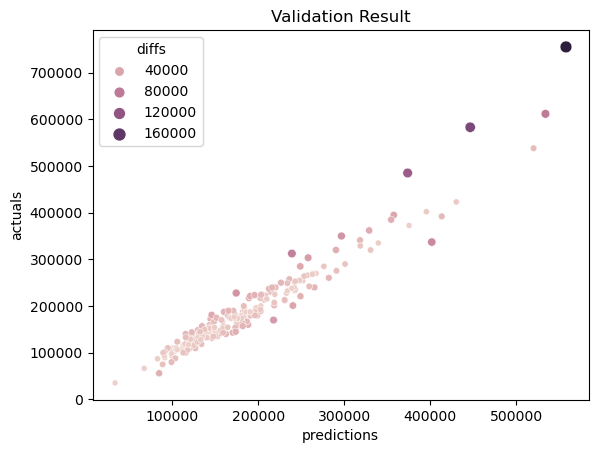

In [69]:
valid_res = pd.DataFrame(valid_results_dict)

# Visualise results
current_time = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
plt.figure()
sns.scatterplot(data=valid_res, 
                x='predictions', y='actuals', size='diffs', hue='diffs')
plt.title('Validation Result')
plt.show()

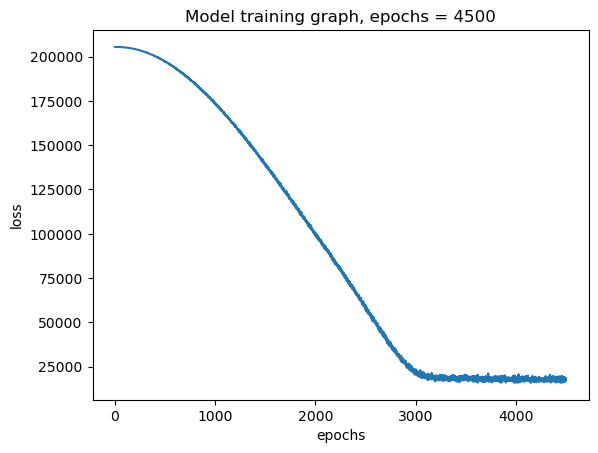

In [73]:
# Produce validation graph
losses_collapsed = [losses[i].item() for i in range(len(epochs))]
epochs = [ep+1 for ep in range(len(epochs))]
eval_df = pd.DataFrame({
    'epochs': epochs,
    'loss': losses_collapsed
})


plt.figure()
palette = sns.color_palette("mako_r", 6)
sns.lineplot(data=eval_df, x='epochs', y='loss', palette=palette)
plt.title('Model training graph, epochs = 4500')
plt.show()

In [17]:
emb_szs1 = [(1120, 50), (15, 8), (107, 50), (816, 50), (9, 5), (8, 4), (109, 50), (61, 31), (282, 50), (524, 50), (108, 50), (678, 50), (623, 50), (655, 50), (350, 50), (727, 50), (3, 2), (3, 2), (4, 2), (3, 2), (7, 4), (3, 2), (10, 5), (4, 2), (97, 49), (4, 2), (394, 50), (222, 50), (176, 50), (99, 50), (16, 8), (63, 32), (7, 4), (17, 9), (12, 6), (5, 3), (570, 50)]

In [18]:
torch.manual_seed(123)
model = MLPRegressor(emb_szs1, conts.shape[1], out_sz=1, layers=[200,100], p=0.4)
print('[INFO] Model definition')
print(model)
print('='* 80)

[INFO] Model definition
MLPRegressor(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(3, 2)
    (2): Embedding(5, 3)
    (3): Embedding(1, 1)
    (4): Embedding(5, 3)
    (5): Embedding(7, 4)
    (6): Embedding(5, 3)
    (7): Embedding(16, 8)
    (8): Embedding(3, 2)
    (9): Embedding(4, 2)
    (10): Embedding(6, 3)
    (11): Embedding(5, 3)
    (12): Embedding(6, 3)
    (13): Embedding(6, 3)
    (14): Embedding(2, 1)
    (15): Embedding(4, 2)
    (16): Embedding(6, 3)
    (17): Embedding(5, 3)
    (18): Embedding(4, 2)
    (19): Embedding(5, 3)
    (20): Embedding(7, 4)
    (21): Embedding(5, 3)
    (22): Embedding(9, 5)
    (23): Embedding(5, 3)
    (24): Embedding(4, 2)
    (25): Embedding(4, 2)
    (26): Embedding(5, 3)
    (27): Embedding(6, 3)
    (28): Embedding(4, 2)
    (29): Embedding(2, 1)
    (30): Embedding(5, 3)
    (31): Embedding(8, 4)
    (32): Embedding(4, 2)
    (33): Embedding(5, 3)
    (34): Embedding(25, 13)
    (35): Embedding(5, 3)
    (36):

In [19]:
model_infer = MLPRegressor(emb_szs1, conts.shape[1], 1, [200,100], p=0.4)
model_infer.load_state_dict(torch.load('model_artifacts/housing_price_400.pt'))
print(model_infer.eval())

RuntimeError: Error(s) in loading state_dict for MLPRegressor:
	size mismatch for embeds.0.weight: copying a param with shape torch.Size([25, 13]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.1.weight: copying a param with shape torch.Size([7, 4]) from checkpoint, the shape in current model is torch.Size([3, 2]).
	size mismatch for embeds.3.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([1, 1]).
	size mismatch for embeds.5.weight: copying a param with shape torch.Size([14, 7]) from checkpoint, the shape in current model is torch.Size([7, 4]).
	size mismatch for embeds.6.weight: copying a param with shape torch.Size([6, 3]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.7.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([16, 8]).
	size mismatch for embeds.8.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([3, 2]).
	size mismatch for embeds.9.weight: copying a param with shape torch.Size([2, 1]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.10.weight: copying a param with shape torch.Size([2, 1]) from checkpoint, the shape in current model is torch.Size([6, 3]).
	size mismatch for embeds.13.weight: copying a param with shape torch.Size([7, 4]) from checkpoint, the shape in current model is torch.Size([6, 3]).
	size mismatch for embeds.14.weight: copying a param with shape torch.Size([3, 2]) from checkpoint, the shape in current model is torch.Size([2, 1]).
	size mismatch for embeds.15.weight: copying a param with shape torch.Size([9, 5]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.16.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([6, 3]).
	size mismatch for embeds.17.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.18.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.20.weight: copying a param with shape torch.Size([3, 2]) from checkpoint, the shape in current model is torch.Size([7, 4]).
	size mismatch for embeds.21.weight: copying a param with shape torch.Size([7, 4]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.22.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([9, 5]).
	size mismatch for embeds.23.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.25.weight: copying a param with shape torch.Size([3, 2]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.26.weight: copying a param with shape torch.Size([8, 4]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.27.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([6, 3]).
	size mismatch for embeds.28.weight: copying a param with shape torch.Size([6, 3]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.29.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([2, 1]).
	size mismatch for embeds.31.weight: copying a param with shape torch.Size([6, 3]) from checkpoint, the shape in current model is torch.Size([8, 4]).
	size mismatch for embeds.32.weight: copying a param with shape torch.Size([9, 5]) from checkpoint, the shape in current model is torch.Size([4, 2]).
	size mismatch for embeds.34.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([25, 13]).
	size mismatch for embeds.35.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.36.weight: copying a param with shape torch.Size([3, 2]) from checkpoint, the shape in current model is torch.Size([5, 3]).
	size mismatch for embeds.37.weight: copying a param with shape torch.Size([6, 3]) from checkpoint, the shape in current model is torch.Size([3, 2]).
	size mismatch for embeds.38.weight: copying a param with shape torch.Size([4, 2]) from checkpoint, the shape in current model is torch.Size([14, 7]).
	size mismatch for embeds.39.weight: copying a param with shape torch.Size([5, 3]) from checkpoint, the shape in current model is torch.Size([3, 2]).
	size mismatch for embeds.40.weight: copying a param with shape torch.Size([16, 8]) from checkpoint, the shape in current model is torch.Size([9, 5]).
	size mismatch for embeds.41.weight: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([7, 4]).

In [ ]:
def prod_data(model, cat_prod, cont_prod, verbose=False):
    # Pass the inputs from the cont and cat tensors to function
    with torch.no_grad():
        y_val = model(cat_prod, cont_prod)
    
    # Get preds on prod data
    preds = [] 
    for i in range(len(cat_prod)):
        result = y_val[i].item()
        preds.append(result)
        
        if verbose == True:
            print(f'The predicted value is: {y_val[i].item()}')
        
    return preds

In [ ]:
prod = prod_data(model_infer, cats, conts, verbose=True)
# Print out prod
print(len(prod))

In [ ]:
plt.scatter(y.numpy(), prod)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted values and Actual values ')
plt.show()